In [80]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Functions

In [2]:
def parse_file(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    total_sum = data['interaction'].sum()
    cis_contacts = data[data['chr1'] == data['chr2']]['interaction'].sum()
    trans_contacts = data[data['chr1'] != data['chr2']]['interaction'].sum()
    if trans_contacts == 0:
        cis_trans_ratio = float('inf')  # To handle division by zero
    else:
        cis_trans_ratio = cis_contacts / trans_contacts

    if total_sum >= 1000 and cis_trans_ratio >= 1:
        return data
    print(f"SKIPPED {file_path}")
    return None

def calculate_interchromosomal_log_sums(data):
    # Define chromosome list with chrX and chr1 to chr22
    chromosomes = ['chrX'] + ['chr' + str(i) for i in range(1, 23)]
    # Initialize a dictionary to store the log10 sums of interchromosomal interactions
    contact_sums = {}

    # Calculate interactions for chrX with chr1 through chr22
    chrX = chromosomes[0]
    for j in range(1, len(chromosomes)):
        chrB = chromosomes[j]
        
        # Filter rows where chr1 = chrX and chr2 = chrB, or vice versa
        filtered_data = data[((data['chr1'] == chrX) & (data['chr2'] == chrB))]
        # Sum the interaction counts for the filtered rows
        total_contacts = filtered_data['interaction'].sum()
        # Take log10 of the contact sum, handling cases where the sum is 0
        if total_contacts > 0:
            contact_sums[f'{chrX}-{chrB}'] = np.log10(total_contacts)
        else:
            contact_sums[f'{chrX}-{chrB}'] = 0  # Set log10(0) to negative infinity

    # Calculate interactions for remaining chromosomes (chr22 down to chr2)
    for i in range(len(chromosomes) - 1, 1, -1):
        chrA = chromosomes[i]

        # For each chromosome, calculate interaction with all preceding chromosomes
        for j in range(1, i):
            chrB = chromosomes[j]
            
            # Filter rows where chr1 = chrA and chr2 = chrB, or vice versa
            filtered_data = data[((data['chr1'] == chrA) & (data['chr2'] == chrB))]

            # Sum the interaction counts for the filtered rows
            total_contacts = filtered_data['interaction'].sum()
            
            # Take log10 of the contact sum, handling cases where the sum is 0
            if total_contacts > 0:
                contact_sums[f'{chrA}-{chrB}'] = np.log10(total_contacts)
            else:
                contact_sums[f'{chrA}-{chrB}'] = 0  # Set log10(0) to negative infinity
    
    return contact_sums

def count_non_zero_interactions(data):
    filtered_data = data[(data['chr1'] != data['chr2'])]
    # Return the number of occurrences
    return len(filtered_data)



In [3]:
# Define the expected set of chromosomes
expected_chromosomes = {'chr' + str(i) for i in range(1, 23)}  # chr1 to chr22
expected_chromosomes.add('chrX')  # Adding chrx to the set

def check_all_chromosomes_present(file_path):
    """
    Function to check if a file contains all chromosomes from chr1 to chr22, and chrx.

    Args:
        file_path (str): Path to the text file to check.

    Returns:
        bool: True if all required chromosomes are present, False otherwise.
        missing_chromosomes (list): List of missing chromosomes (if any).
    """
    # Read the file using pandas (assuming it's a tab-separated file with columns for chr1 and chr2)
    data = pd.read_csv(file_path, sep='\t', header=None, names=['chr1', 'pos1', 'chr2', 'pos2', 'interaction'])
    
    # Extract unique chromosomes from the chr1 and chr2 columns
    unique_chromosomes = set(data['chr1'].unique()).union(set(data['chr2'].unique()))
    
    # Convert to lowercase to handle case differences
    unique_chromosomes = {chr for chr in unique_chromosomes}
    
    # Check for missing chromosomes
    missing_chromosomes = expected_chromosomes - unique_chromosomes
    
    if missing_chromosomes:
        return False, missing_chromosomes
    return True, []

In [4]:
def create_large_intrachromosomal_matrix(chr_matrices, chr_sizes, chromosomes):
    """
    Function to create a large matrix with chromosome contact matrices on the diagonal.

    Args:
        chr_matrices (list): A list of intrachromosomal matrices (one for each chromosome).
        chr_sizes (dict): Dictionary with chromosome names as keys and their sizes as values.
        chromosomes (list): List of chromosome names in the order they should appear in the final matrix.

    Returns:
        np.array: A large matrix with the intrachromosomal matrices on the diagonal.
    """
    # Determine the total size of the large matrix
    total_size = sum([chr_sizes[chrom] for chrom in chromosomes])

    # Initialize the large matrix
    large_matrix = np.zeros((total_size, total_size))

    # Place each chromosome matrix on the diagonal
    current_index = 0
    for i, chromosome in enumerate(chromosomes):
        chr_size = chr_sizes[chromosome]
        chr_matrix = chr_matrices[i]
        
        # Place the intrachromosomal matrix in the correct position in the large matrix
        large_matrix[current_index:current_index + chr_size, current_index:current_index + chr_size] = chr_matrix
        current_index += chr_size

    return large_matrix

# Function to visualize the large matrix
def plot_large_matrix(matrix, title="Intrachromosomal Contact Matrix"):
    """
    Function to plot the large matrix.

    Args:
        matrix (np.array): The large matrix to be visualized.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, cmap='viridis', square=True, cbar=True)
    plt.title(title)
    plt.xlabel('Chromosomal Positions')
    plt.ylabel('Chromosomal Positions')
    plt.show()

# Checking missing chromosomes and Interchromosomal Contacts

In [5]:
for file in os.listdir("GM12878"):
    file_path = os.path.join("GM12878", file)
    has_all_chromosomes, missing = check_all_chromosomes_present(file_path)
    if not has_all_chromosomes:
        print(f"MISSING CHROMOSOMES: {file} - {missing}")

In [6]:
sample_data = parse_file("GM12878/ml3_AAGCGACC-ACCTCTTG.txt")
intra_counts = count_non_zero_interactions(sample_data)
print(intra_counts)
calculate_interchromosomal_log_sums(sample_data)

0


{'chrX-chr1': 0,
 'chrX-chr2': 0,
 'chrX-chr3': 0,
 'chrX-chr4': 0,
 'chrX-chr5': 0,
 'chrX-chr6': 0,
 'chrX-chr7': 0,
 'chrX-chr8': 0,
 'chrX-chr9': 0,
 'chrX-chr10': 0,
 'chrX-chr11': 0,
 'chrX-chr12': 0,
 'chrX-chr13': 0,
 'chrX-chr14': 0,
 'chrX-chr15': 0,
 'chrX-chr16': 0,
 'chrX-chr17': 0,
 'chrX-chr18': 0,
 'chrX-chr19': 0,
 'chrX-chr20': 0,
 'chrX-chr21': 0,
 'chrX-chr22': 0,
 'chr22-chr1': 0,
 'chr22-chr2': 0,
 'chr22-chr3': 0,
 'chr22-chr4': 0,
 'chr22-chr5': 0,
 'chr22-chr6': 0,
 'chr22-chr7': 0,
 'chr22-chr8': 0,
 'chr22-chr9': 0,
 'chr22-chr10': 0,
 'chr22-chr11': 0,
 'chr22-chr12': 0,
 'chr22-chr13': 0,
 'chr22-chr14': 0,
 'chr22-chr15': 0,
 'chr22-chr16': 0,
 'chr22-chr17': 0,
 'chr22-chr18': 0,
 'chr22-chr19': 0,
 'chr22-chr20': 0,
 'chr22-chr21': 0,
 'chr21-chr1': 0,
 'chr21-chr2': 0,
 'chr21-chr3': 0,
 'chr21-chr4': 0,
 'chr21-chr5': 0,
 'chr21-chr6': 0,
 'chr21-chr7': 0,
 'chr21-chr8': 0,
 'chr21-chr9': 0,
 'chr21-chr10': 0,
 'chr21-chr11': 0,
 'chr21-chr12': 0,
 'ch

In [7]:
for file in tqdm(os.listdir("HAP1")):
    if file.endswith(".txt"):
        data = parse_file(f"HAP1/{file}")
        if data is not None:
            inter_counts = count_non_zero_interactions(data)

100%|██████████| 917/917 [00:02<00:00, 341.11it/s]


# Basic setup

In [8]:
# Define the directories and max_bin
directories = {
    'GM12878': './GM12878',
    'HAP1': './HAP1',
    'Hela': './Hela',
    'K562': './K562'
}

max_bin = {
    'chr1': 230,
    'chr2': 242,
    'chr3': 196,
    'chr4': 190,
    'chr5': 179,
    'chr6': 168,
    'chr7': 158,
    'chr8': 145,
    'chr9': 125,
    'chr10': 134,
    'chr11': 133,
    'chr12': 132,
    'chr13': 97,
    'chr14': 89,
    'chr15': 83,
    'chr16': 81,
    'chr17': 80,
    'chr18': 77,
    'chr19': 58,
    'chr20': 61,
    'chr21': 38,
    'chr22': 36,
    'chrX': 152
}

In [9]:
def load_chromosome_matrix(data, chromosome, chr_size):
    """
    Function to load an intrachromosomal contact matrix for a specific chromosome.
    
    Args:
        data (pd.DataFrame): Hi-C data for a specific cell.
        chromosome (str): The chromosome name (e.g., 'chr1').
        chr_size (int): Size of the chromosome in terms of bin counts.
        
    Returns:
        np.array: Upper triangular intrachromosomal contact matrix for the specified chromosome.
    """
    # Filter for specified chromosome interactions and exclude diagonal (where pos1 == pos2)
    chr_data = data[(data['chr1'] == chromosome) & (data['chr2'] == chromosome) & (data['pos1'] != data['pos2'])]
    
    # Initialize matrix for the specified chromosome
    chr_matrix = np.zeros((chr_size, chr_size))
    
    # Populate the matrix with interaction data
    for _, row in chr_data.iterrows():
        pos1 = row['pos1'] // 1000000
        pos2 = row['pos2'] // 1000000
        interaction = row['interaction']
        if abs(pos1 - pos2) < 3:
            interaction = 0
        if interaction != 0:
            interaction = 1
        
        if pos1 < chr_size and pos2 < chr_size:
            # Only update the upper triangular part
            if pos1 < pos2:
                chr_matrix[pos1, pos2] += interaction
            elif pos2 < pos1:
                chr_matrix[pos2, pos1] += interaction  # Ensure symmetry for intra-chromosomal interactions
    
    return np.triu(chr_matrix)  # Ensure that only the upper triangular part is returned

def load_all_chromosome_matrices_for_cell(data, chromosomes, chr_sizes, smoothing: bool):
    """
    Function to load a list of intrachromosomal contact matrices for all specified chromosomes in a cell.
    
    Args:
        data (pd.DataFrame): Hi-C data for a specific cell.
        chromosomes (list): List of chromosome names (e.g., ['chr1', 'chr2', ...]).
        chr_sizes (dict): Dictionary with chromosome names as keys and their sizes as values.
        
    Returns:
        list: A list of intrachromosomal matrices, one for each chromosome in the list.
    """
    chr_matrices = []
    
    # Iterate over all chromosomes to load intrachromosomal contact matrices
    for chromosome in chromosomes:
        if chromosome in chr_sizes:
            chr_size = chr_sizes[chromosome]
            chr_matrix = load_chromosome_matrix(data, chromosome, chr_size)
            if smoothing:
                kernel = np.ones((3, 3)) / 9.0
                chr_matrix = convolve2d(chr_matrix, kernel, mode='same', boundary='symm')
            chr_matrices.append(chr_matrix)
        else:
            print(f"Chromosome {chromosome} not found in chr_sizes, skipping.")
    
    return chr_matrices

In [10]:
chromosomes = max_bin.keys()

In [11]:
def vectorize_upper_triangular(matrix):
    vector = matrix[np.triu_indices(matrix.shape[0], k=1)]
    return vector

In [12]:
def concatenate(intrachromosomal_matrices, interchromosomal_log_sums):
    """
    Assemble a long vector representing the entire cell's intra- and inter-chromosomal contacts.
    
    Args:
        intrachromosomal_matrices (list): List of 23 intrachromosomal matrices for chr1 to chrX.
        interchromosomal_log_sums (dict): Dictionary containing log10 of interchromosomal contact sums.
    
    Returns:
        np.array: A long vector representing the entire cell's contact data.
    """
    long_vector = []
    num_chromosomes = len(intrachromosomal_matrices)

    # Iterate through each chromosome
    for i in range(num_chromosomes):
        chr_i = f'chr{i+1}'
        
        # 1. Vectorize the intrachromosomal matrix (upper triangular)
        intra_vector = vectorize_upper_triangular(intrachromosomal_matrices[i])
        long_vector.extend(intra_vector)  # Append vectorized matrix to the long vector
        
        # 2. Append interchromosomal values for chr_i and all chromosomes > i
        # for j in range(i + 1, num_chromosomes):  # Skip symmetric cases
        #     chr_j = f'chr{j+1}'
        #     key = f'{chr_i}-{chr_j}'
        #     log_sum_value = interchromosomal_log_sums.get(key, 0)  # Get the log sum from the dictionary
        #     long_vector.append(log_sum_value)  # Append the inter-chromosomal log sum value

    return np.array(long_vector)



# Loading in the matrices and concatenated vectors

In [25]:
GM12878_matrices = []
GM12878_concatenated = []
for cell in tqdm(sorted(os.listdir("GM12878"))):
    if cell.endswith(".txt"):
        data = parse_file(f"GM12878/{cell}")
        if data is not None:
            cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin, smoothing=False)
            GM12878_matrices.append(cell_matrices)
            interchromosomal_log_sums = calculate_interchromosomal_log_sums(data)
            long_vector = concatenate(cell_matrices, interchromosomal_log_sums)
            GM12878_concatenated.append(long_vector)
            
HAP1_matrices = []
HAP1_concatenated = []
for cell in tqdm(sorted(os.listdir("HAP1"))):
    if cell.endswith(".txt"):
        data = parse_file(f"HAP1/{cell}")
        if data is not None:
            cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin, smoothing=False)
            HAP1_matrices.append(cell_matrices)
            interchromosomal_log_sums = calculate_interchromosomal_log_sums(data)
            long_vector = concatenate(cell_matrices, interchromosomal_log_sums)
            HAP1_concatenated.append(long_vector)

Hela_matrices = []
Hela_concatenated = []
for cell in tqdm(sorted(os.listdir("Hela"))):
    if cell.endswith(".txt"):
        data = parse_file(f"Hela/{cell}")
        if data is not None:
            cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin, smoothing=False)
            Hela_matrices.append(cell_matrices)
            interchromosomal_log_sums = calculate_interchromosomal_log_sums(data)
            long_vector = concatenate(cell_matrices, interchromosomal_log_sums)
            Hela_concatenated.append(long_vector)

K562_matrices = []
K562_concatenated = []
for cell in tqdm(sorted(os.listdir("K562"))):
    if cell.endswith(".txt"):
        data = parse_file(f"K562/{cell}")
        if data is not None:
            cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin, smoothing=False)
            K562_matrices.append(cell_matrices)
            interchromosomal_log_sums = calculate_interchromosomal_log_sums(data)
            long_vector = concatenate(cell_matrices, interchromosomal_log_sums)
            K562_concatenated.append(long_vector)

100%|██████████| 48/48 [00:07<00:00,  6.33it/s]


In [26]:
print(len(GM12878_matrices), len(HAP1_matrices), len(Hela_matrices), len(K562_matrices))
print(len(GM12878_concatenated), len(HAP1_concatenated), len(Hela_concatenated), len(K562_concatenated))
print(GM12878_concatenated[0].shape, HAP1_concatenated[0].shape, Hela_concatenated[0].shape, K562_concatenated[0].shape)

24 917 1622 48
24 917 1622 48
(217041,) (217041,) (217041,) (217041,)


In [27]:
# Combine all cells from all types into one matrix
combined_cells = np.vstack([
    HAP1_concatenated,
    GM12878_concatenated,
    Hela_concatenated,
    K562_concatenated
])

labels = (
    [0] * len(HAP1_concatenated) +
    [1] * len(GM12878_concatenated) +
    [2] * len(Hela_concatenated) +
    [3] * len(K562_concatenated)
)
labels = np.array(labels)

# PCA on the concatenated vectors

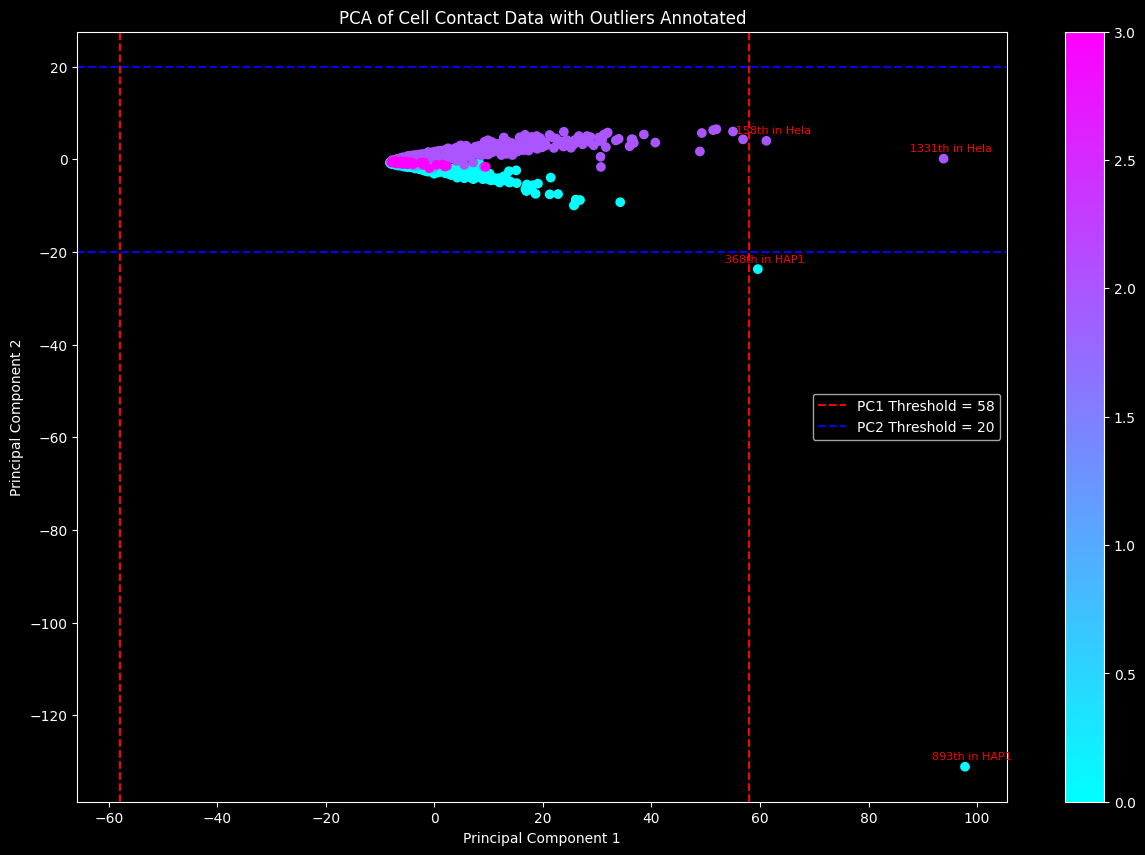

Outliers identified: [ 368  893 1099 2272]
Outlier 368: 368th data point in HAP1
Outlier 893: 893th data point in HAP1
Outlier 1099: 158th data point in Hela
Outlier 2272: 1331th data point in Hela


In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
transformed_data = pca.fit_transform(combined_cells)
fig, ax = plt.subplots(figsize=(15, 10))

# Scatter plot with the first and second principal components
scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, cmap='cool')

plt.colorbar(scatter)

# Define outlier thresholds for both PC1 and PC2
pc1_threshold = 58  # Adjust this based on your data for PC1
pc2_threshold = 20  # Adjust this based on your data for PC2

# Find outliers for both PC1 and PC2
outliers_pc1 = np.where(np.abs(transformed_data[:, 0]) > pc1_threshold)[0]
outliers_pc2 = np.where(np.abs(transformed_data[:, 1]) > pc2_threshold)[0]

# Combine outliers (either from PC1 or PC2)
outliers = np.unique(np.concatenate([outliers_pc1, outliers_pc2]))

# Track the indices for each cell type
cell_type_indices = {
    'HAP1': np.where(labels == 0)[0],
    'GM12878': np.where(labels == 1)[0],
    'Hela': np.where(labels == 2)[0],
    'K562': np.where(labels == 3)[0]
}

# Define a reverse mapping of labels to cell types for annotation
label_to_cell_type = {
    0: 'HAP1',
    1: 'GM12878',
    2: 'Hela',
    3: 'K562'
}

# Annotate outliers
for i in outliers:
    # Determine the cell type for the current point
    cell_type = label_to_cell_type[labels[i]]
    
    # Find the local index of the point within its cell type
    local_index = np.where(cell_type_indices[cell_type] == i)[0][0]
    
    # Annotate the point with the local index and cell type
    ax.annotate(f"{local_index}th in {cell_type}", 
                (transformed_data[i, 0], transformed_data[i, 1]),
                textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='red')

# Plot threshold lines for outlier detection on PC1 (vertical) and PC2 (horizontal)
ax.axvline(x=pc1_threshold, color='red', linestyle='--', label=f'PC1 Threshold = {pc1_threshold}')
ax.axvline(x=-pc1_threshold, color='red', linestyle='--')

ax.axhline(y=pc2_threshold, color='blue', linestyle='--', label=f'PC2 Threshold = {pc2_threshold}')
ax.axhline(y=-pc2_threshold, color='blue', linestyle='--')

# Set plot title and labels
ax.set_title('PCA of Cell Contact Data with Outliers Annotated')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Show legend for threshold lines
plt.legend()

# Show the plot
plt.show()

# List of the outliers
print(f"Outliers identified: {outliers}")
for i in outliers:
    cell_type = label_to_cell_type[labels[i]]
    local_index = np.where(cell_type_indices[cell_type] == i)[0][0]
    print(f"Outlier {i}: {local_index}th data point in {cell_type}")


# Remove Outliers

In [29]:
# Get sorted file lists from the directories
hap1_dir = "HAP1"
hela_dir = "Hela"

hap1_files = sorted(os.listdir(hap1_dir))
hela_files = sorted(os.listdir(hela_dir))

# Define the outlier indices
outliers_hap1 = [369, 894]  # Outlier data points for HAP1
outliers_hela = [159, 1332]  # Outlier data points for Hela

# Find the corresponding files in HAP1
print("Outlier Files in HAP1:")
for outlier_idx in outliers_hap1:
    if outlier_idx - 1 < len(hap1_files):
        full_path = os.path.join(hap1_dir, hap1_files[outlier_idx - 1])
        print(f"Outlier {outlier_idx}: {full_path}")
    else:
        print(f"Outlier {outlier_idx} exceeds file count in HAP1 directory.")

# Find the corresponding files in Hela
print("\nOutlier Files in Hela:")
for outlier_idx in outliers_hela:
    if outlier_idx - 1 < len(hela_files):
        full_path = os.path.join(hela_dir, hela_files[outlier_idx - 1])
        print(f"Outlier {outlier_idx}: {full_path}")
    else:
        print(f"Outlier {outlier_idx} exceeds file count in Hela directory.")


Outlier Files in HAP1:
Outlier 369: HAP1/ml2_TCCGACGC-TCGTGAAG.txt
Outlier 894: HAP1/pl2_TGAGCCAC-AGCATATG.txt

Outlier Files in Hela:
Outlier 159: Hela/ml1_GCCTTAGG-ATGCTTAA.txt
Outlier 1332: Hela/pl2_GAGGAGCA-CGCTTAAT.txt


In [31]:
HAP1_outliers = ["ml2_TCCGACGC-TCGTGAAG.txt", "pl2_TGAGCCAC-AGCATATG.txt"]
Hela_outliers = ["ml1_GCCTTAGG-ATGCTTAA.txt", "pl2_GAGGAGCA-CGCTTAAT.txt"]

HAP1_concatenated = []
for cell in tqdm(sorted(os.listdir("HAP1"))):
    if cell.endswith(".txt") and cell not in HAP1_outliers:
        data = parse_file(f"HAP1/{cell}")
        if data is not None:
            cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin, smoothing=False)
            interchromosomal_log_sums = calculate_interchromosomal_log_sums(data)
            long_vector = concatenate(cell_matrices, interchromosomal_log_sums)
            HAP1_concatenated.append(long_vector)
            
Hela_concatenated = []
for cell in tqdm(sorted(os.listdir("Hela"))):
    if cell.endswith(".txt") and cell not in Hela_outliers:
        data = parse_file(f"Hela/{cell}")
        if data is not None:
            cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin, False)
            interchromosomal_log_sums = calculate_interchromosomal_log_sums(data)
            long_vector = concatenate(cell_matrices, interchromosomal_log_sums)
            Hela_concatenated.append(long_vector)


# Combine all cells from all types into one matrix
combined_cells = np.vstack([
    HAP1_concatenated,
    GM12878_concatenated,
    Hela_concatenated,
    K562_concatenated
])

labels = (
    [0] * len(HAP1_concatenated) +
    [1] * len(GM12878_concatenated) +
    [2] * len(Hela_concatenated) +
    [3] * len(K562_concatenated)
)
labels = np.array(labels)

100%|██████████| 1622/1622 [06:32<00:00,  4.13it/s]


# PCA After Removing Outliers

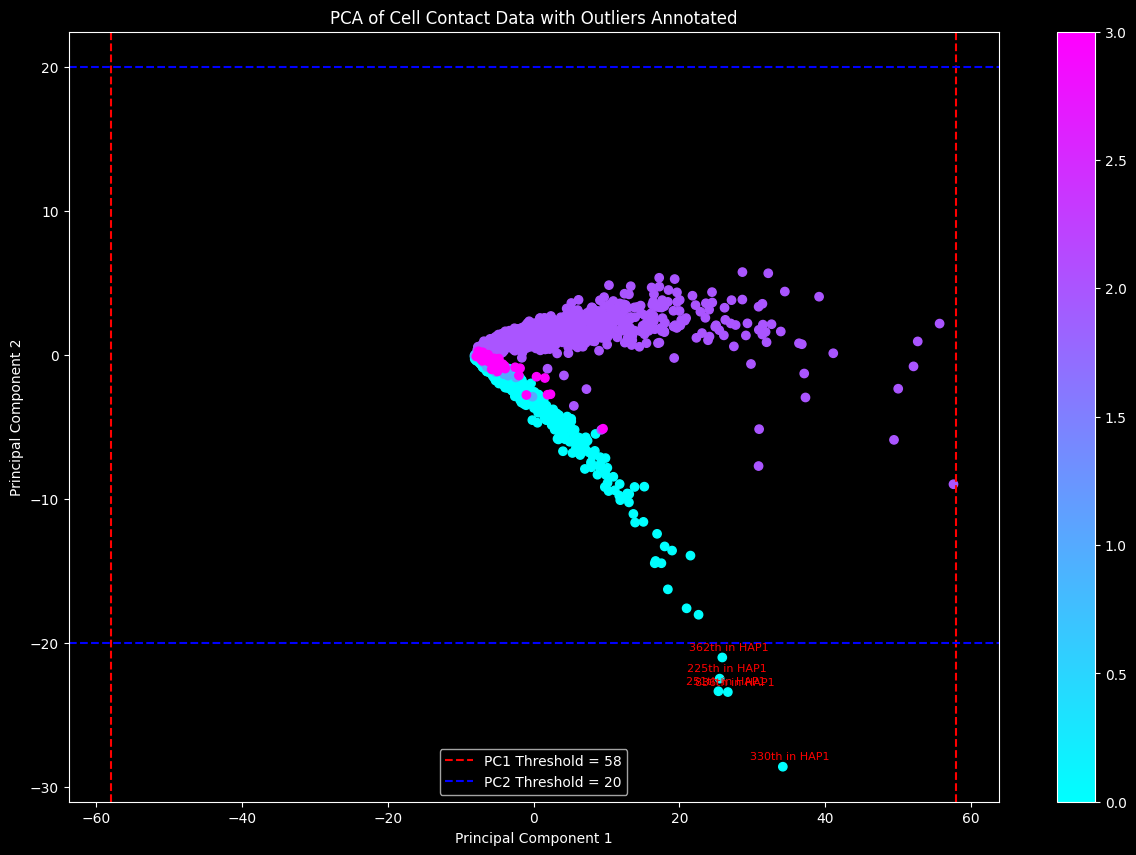

Outliers identified: [225 251 330 362 836]
Outlier 225: 225th data point in HAP1
Outlier 251: 251th data point in HAP1
Outlier 330: 330th data point in HAP1
Outlier 362: 362th data point in HAP1
Outlier 836: 836th data point in HAP1


In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assuming combined_cells is your dataset and labels are stored in 'labels'
# Example PCA transformation (assuming you have performed PCA)
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(combined_cells)


fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the figsize as needed

# Scatter plot with the first and second principal components
scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels, cmap='cool')

# Add a color bar for visualization
plt.colorbar(scatter)

# Define outlier thresholds for both PC1 and PC2
pc1_threshold = 58  # Adjust this based on your data for PC1
pc2_threshold = 20  # Adjust this based on your data for PC2

# Find outliers for both PC1 and PC2
outliers_pc1 = np.where(np.abs(transformed_data[:, 0]) > pc1_threshold)[0]
outliers_pc2 = np.where(np.abs(transformed_data[:, 1]) > pc2_threshold)[0]

# Combine outliers (either from PC1 or PC2)
outliers = np.unique(np.concatenate([outliers_pc1, outliers_pc2]))

# Track the indices for each cell type
cell_type_indices = {
    'HAP1': np.where(labels == 0)[0],
    'GM12878': np.where(labels == 1)[0],
    'Hela': np.where(labels == 2)[0],
    'K562': np.where(labels == 3)[0]
}

# Define a reverse mapping of labels to cell types for annotation
label_to_cell_type = {
    0: 'HAP1',
    1: 'GM12878',
    2: 'Hela',
    3: 'K562'
}

# Annotate outliers
for i in outliers:
    # Determine the cell type for the current point
    cell_type = label_to_cell_type[labels[i]]
    
    # Find the local index of the point within its cell type
    local_index = np.where(cell_type_indices[cell_type] == i)[0][0]  # +1 for 1-based index
    
    # Annotate the point with the local index and cell type
    ax.annotate(f"{local_index}th in {cell_type}", 
                (transformed_data[i, 0], transformed_data[i, 1]),
                textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='red')

# Plot threshold lines for outlier detection on PC1 (vertical) and PC2 (horizontal)
ax.axvline(x=pc1_threshold, color='red', linestyle='--', label=f'PC1 Threshold = {pc1_threshold}')
ax.axvline(x=-pc1_threshold, color='red', linestyle='--')

ax.axhline(y=pc2_threshold, color='blue', linestyle='--', label=f'PC2 Threshold = {pc2_threshold}')
ax.axhline(y=-pc2_threshold, color='blue', linestyle='--')

# Set plot title and labels
ax.set_title('PCA of Cell Contact Data with Outliers Annotated')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# Show legend for threshold lines
plt.legend()

# Show the plot
plt.show()

# List of the outliers
print(f"Outliers identified: {outliers}")
for i in outliers:
    cell_type = label_to_cell_type[labels[i]]
    local_index = np.where(cell_type_indices[cell_type] == i)[0][0]
    print(f"Outlier {i}: {local_index}th data point in {cell_type}")


In [61]:
print(f"Combined_Cells.shape = {combined_cells.shape}")
print(f"Labels.shape = {labels.shape}")
print(f"Len of pca_loading[0]= {len(pca.components_[0])}")
print(f"shape of a full matrix = 2884")

Combined_Cells.shape = (2607, 217041)
Labels.shape = (2607,)
Len of pca_loading[0]= 189836
shape of a full matrix = 2884


In [74]:
len(pca.components_[0])

189836

# PCA Loadings for each chromosome

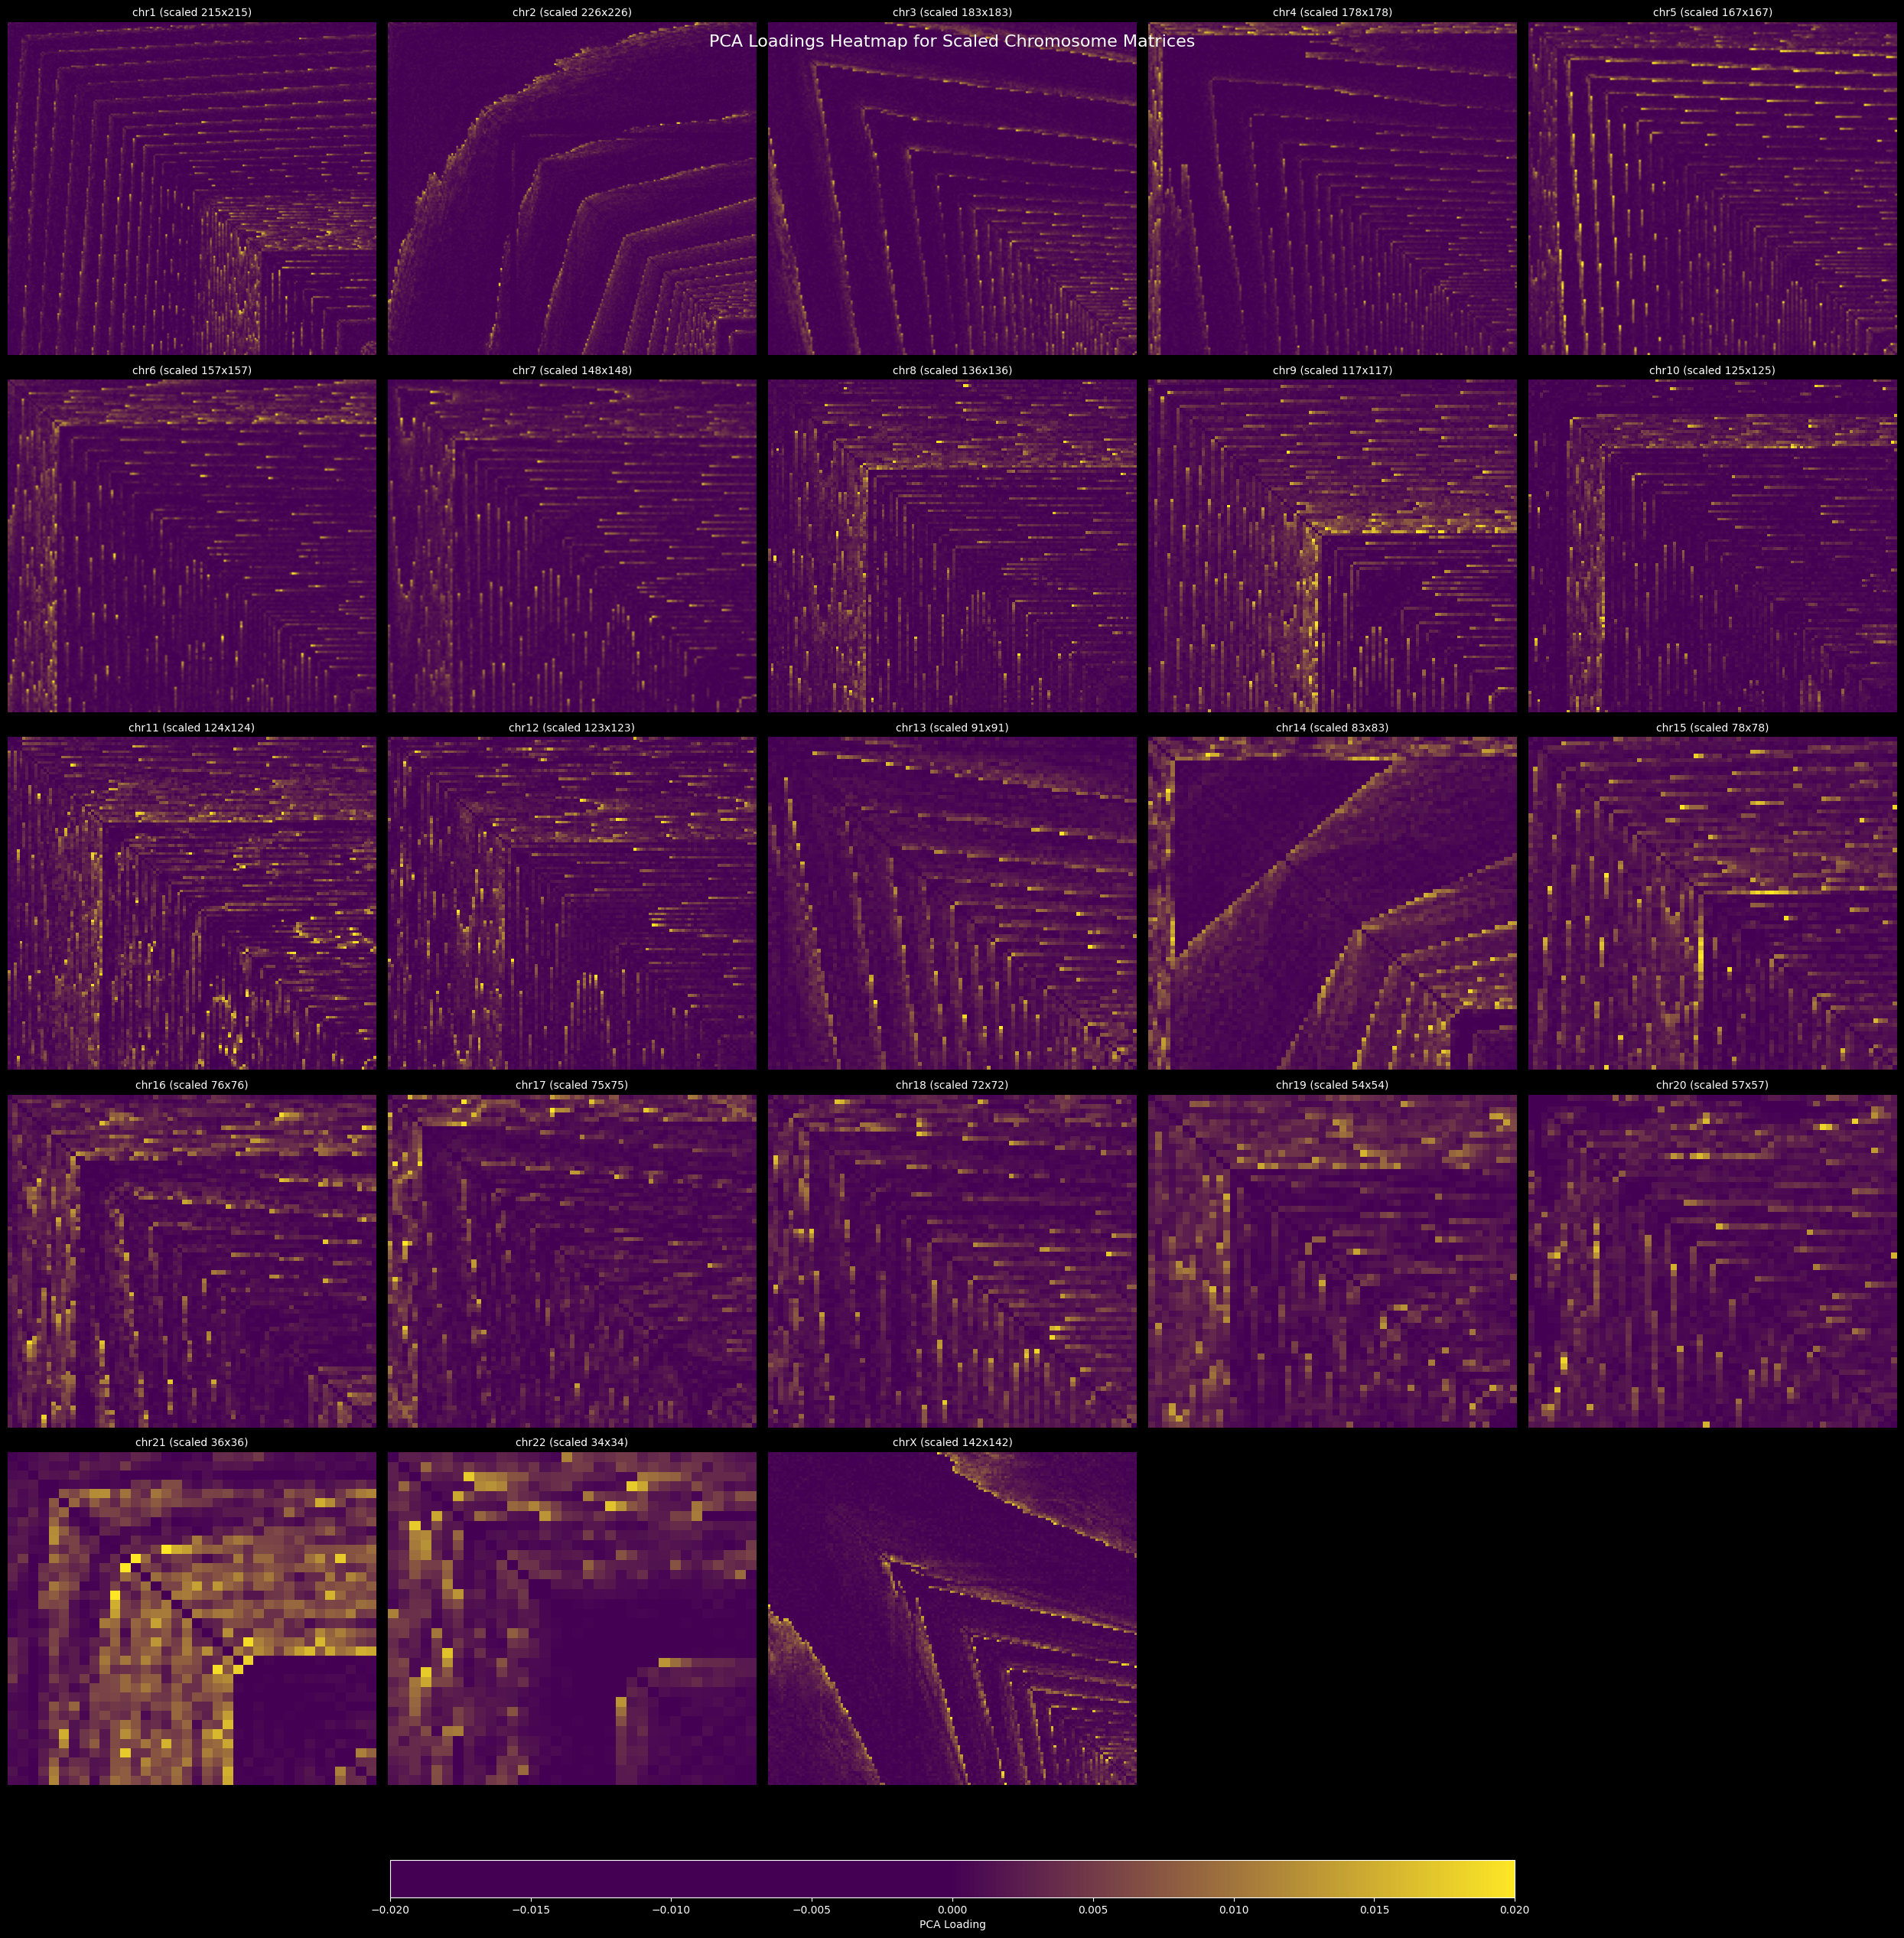

Total loadings used: 189577
Total loadings available: 189836
Scaled sizes: {'chr1': 215, 'chr2': 226, 'chr3': 183, 'chr4': 178, 'chr5': 167, 'chr6': 157, 'chr7': 148, 'chr8': 136, 'chr9': 117, 'chr10': 125, 'chr11': 124, 'chr12': 123, 'chr13': 91, 'chr14': 83, 'chr15': 78, 'chr16': 76, 'chr17': 75, 'chr18': 72, 'chr19': 54, 'chr20': 57, 'chr21': 36, 'chr22': 34, 'chrX': 142}


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
from matplotlib.colors import LinearSegmentedColormap

def calculate_scaled_sizes(chr_sizes, total_loadings):
    total_elements = sum((size * (size - 1)) // 2 for size in chr_sizes.values())
    scale_factor = math.sqrt(total_loadings / total_elements)
    scaled_sizes = {chr: max(2, round(size * scale_factor)) for chr, size in chr_sizes.items()}
    return scaled_sizes

def create_custom_colormap(low_color, high_color):
    return LinearSegmentedColormap.from_list("custom", [low_color, "#440154", high_color])

def create_refined_heatmap(pca, chr_sizes, low_color='#440154', high_color='#FDE725', vmin=-0.02, vmax=0.02):
    loadings = pca.components_[0]
    scaled_sizes = calculate_scaled_sizes(chr_sizes, len(loadings))
    
    fig, axs = plt.subplots(5, 5, figsize=(25, 25))
    axs = axs.ravel()
    
    custom_cmap = create_custom_colormap(low_color, high_color)
    
    start_idx = 0
    for i, (chr_name, size) in enumerate(scaled_sizes.items()):
        num_elements = (size * (size - 1)) // 2
        
        if start_idx + num_elements > len(loadings):
            print(f"Warning: Not enough loadings for {chr_name}. Skipping remaining chromosomes.")
            break
        
        chr_loadings = loadings[start_idx:start_idx + num_elements]
        
        full_matrix = np.zeros((size, size))
        full_matrix[np.triu_indices(size, k=1)] = chr_loadings
        full_matrix = full_matrix + full_matrix.T
        
        im = axs[i].imshow(full_matrix, cmap=custom_cmap, aspect='auto', vmin=vmin, vmax=vmax)
        axs[i].set_title(f'{chr_name} (scaled {size}x{size})', fontsize=10)
        axs[i].axis('off')
        
        start_idx += num_elements
    
    for j in range(i+1, 25):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    cbar = fig.colorbar(im, ax=axs, label='PCA Loading', orientation='horizontal', fraction=0.02, pad=0.04, aspect=30)
    cbar.ax.tick_params(labelsize=10)
    plt.suptitle("PCA Loadings Heatmap for Scaled Chromosome Matrices", fontsize=16)
    plt.show()

    print(f"Total loadings used: {start_idx}")
    print(f"Total loadings available: {len(loadings)}")
    print("Scaled sizes:", scaled_sizes)

# Assuming you've already performed PCA and have the 'pca' object
# pca = PCA(n_components=2)
# transformed_data = pca.fit_transform(combined_cells)

# Create the refined heatmap
create_refined_heatmap(pca, max_bin)

# To adjust colors, you can call the function with custom colors like this:
# create_refined_heatmap(pca, max_bin, low_color='#000033', high_color='#3366FF', vmin=-0.015, vmax=0.015)

# Combined PCA Loadings

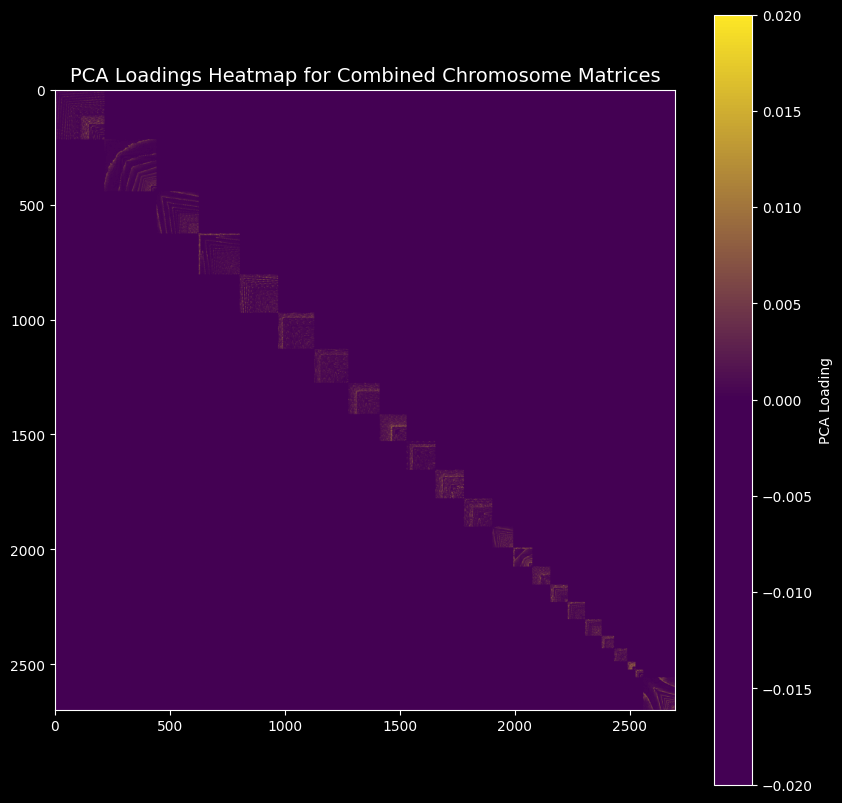

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_custom_colormap(low_color, high_color):
    return LinearSegmentedColormap.from_list("custom", [low_color, "#440154", high_color])

def concatenate_chromosome_matrices(pca, chr_sizes, low_color='#440154', high_color='#FDE725', vmin=-0.02, vmax=0.02):
    """
    Create a large block matrix by placing each chromosome matrix on the diagonal.
    
    Args:
        pca: PCA object after fitting.
        chr_sizes: Dictionary of chromosome sizes.
        low_color: Color for low PCA loadings.
        high_color: Color for high PCA loadings.
        vmin: Minimum value for heatmap.
        vmax: Maximum value for heatmap.
    """
    loadings = pca.components_[0]
    scaled_sizes = calculate_scaled_sizes(chr_sizes, len(loadings))
    
    # Total size of the block matrix
    total_size = sum(scaled_sizes.values())
    
    # Initialize the block matrix with zeros
    block_matrix = np.zeros((total_size, total_size))
    
    # Fill the diagonal blocks with chromosome matrices
    start_idx = 0
    matrix_start = 0
    for chr_name, size in scaled_sizes.items():
        num_elements = (size * (size - 1)) // 2
        
        if start_idx + num_elements > len(loadings):
            print(f"Warning: Not enough loadings for {chr_name}. Skipping remaining chromosomes.")
            break
        
        chr_loadings = loadings[start_idx:start_idx + num_elements]
        
        # Create the full matrix from the upper triangular part
        full_matrix = np.zeros((size, size))
        full_matrix[np.triu_indices(size, k=1)] = chr_loadings
        full_matrix = full_matrix + full_matrix.T
        
        # Place the full matrix in the diagonal block of the block matrix
        block_matrix[matrix_start:matrix_start+size, matrix_start:matrix_start+size] = full_matrix
        
        # Update indices
        matrix_start += size
        start_idx += num_elements
    
    # Plot the block matrix as a heatmap
    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
    custom_cmap = create_custom_colormap(low_color, high_color)
    plt.imshow(block_matrix, cmap=custom_cmap, aspect='equal', vmin=vmin, vmax=vmax)  # Set aspect to 'equal'
    plt.title('PCA Loadings Heatmap for Combined Chromosome Matrices', fontsize=14)
    plt.colorbar(label='PCA Loading')
    plt.show()

# Call this function to generate the combined heatmap
concatenate_chromosome_matrices(pca, max_bin)


# Outlier Cells Visualization

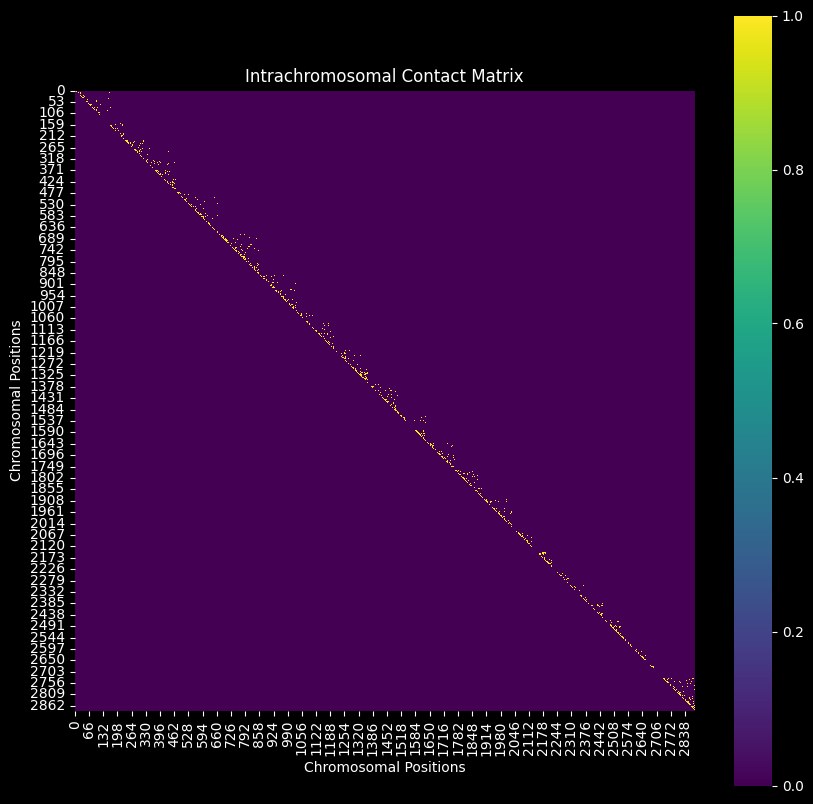

In [137]:
# Load chromosome matrices for a cell
# Assuming 'data' is the Hi-C contact data for a specific cell
outlier_368_data = parse_file("HAP1/ml2_TCCGACGC-TCGTGAAG.txt")
outlier_368 = load_all_chromosome_matrices_for_cell(outlier_368_data, chromosomes, max_bin)

# Create the large matrix
large_matrix = create_large_intrachromosomal_matrix(outlier_368, max_bin, chromosomes)

# Plot the large matrix
plot_large_matrix(large_matrix)


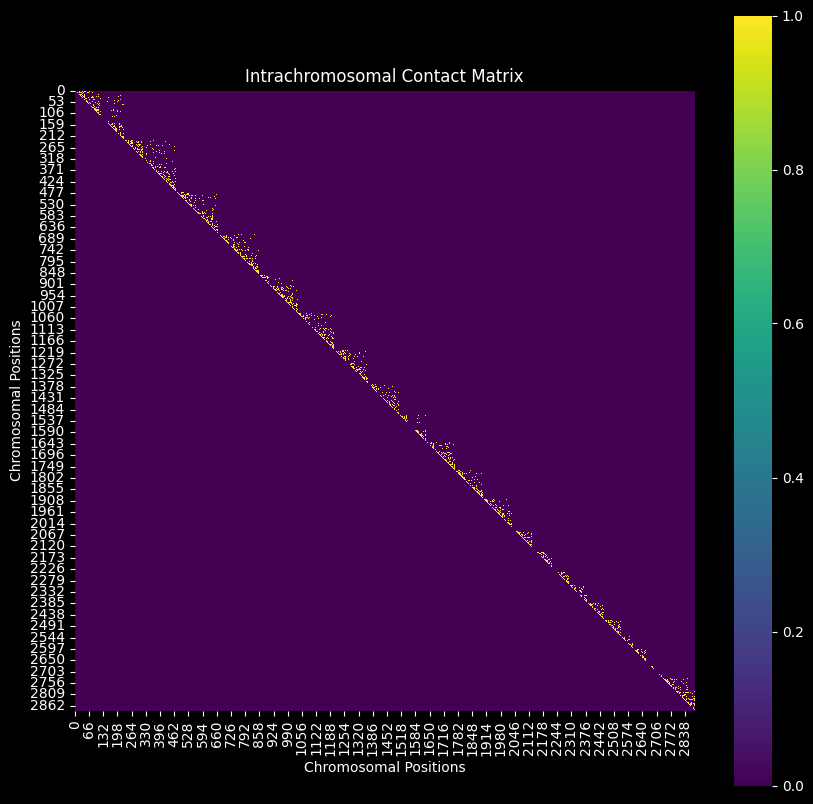

In [138]:
outlier_893_data = parse_file("HAP1/pl2_TGAGCCAC-AGCATATG.txt")
outlier_893 = load_all_chromosome_matrices_for_cell(outlier_893_data, chromosomes, max_bin)

# Create the large matrix
large_matrix = create_large_intrachromosomal_matrix(outlier_893, max_bin, chromosomes)

# Plot the large matrix
plot_large_matrix(large_matrix)


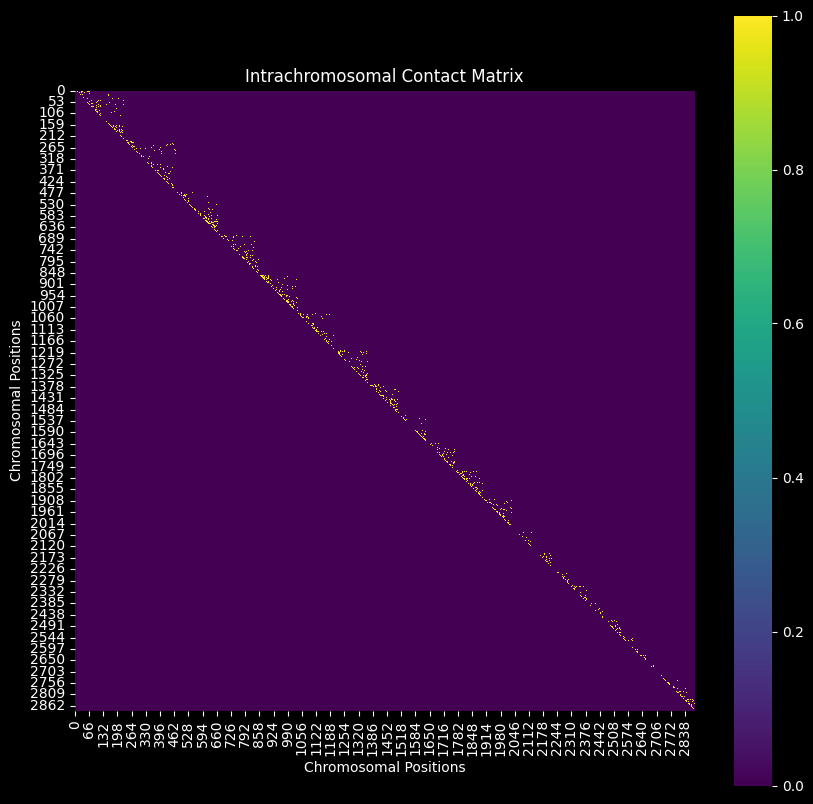

In [140]:
outlier_158_data = parse_file("Hela/ml1_GCCTTAGG-ATGCTTAA.txt")
outlier_158 = load_all_chromosome_matrices_for_cell(outlier_158_data, chromosomes, max_bin)

# Create the large matrix
large_matrix = create_large_intrachromosomal_matrix(outlier_158, max_bin, chromosomes)

# Plot the large matrix
plot_large_matrix(large_matrix)

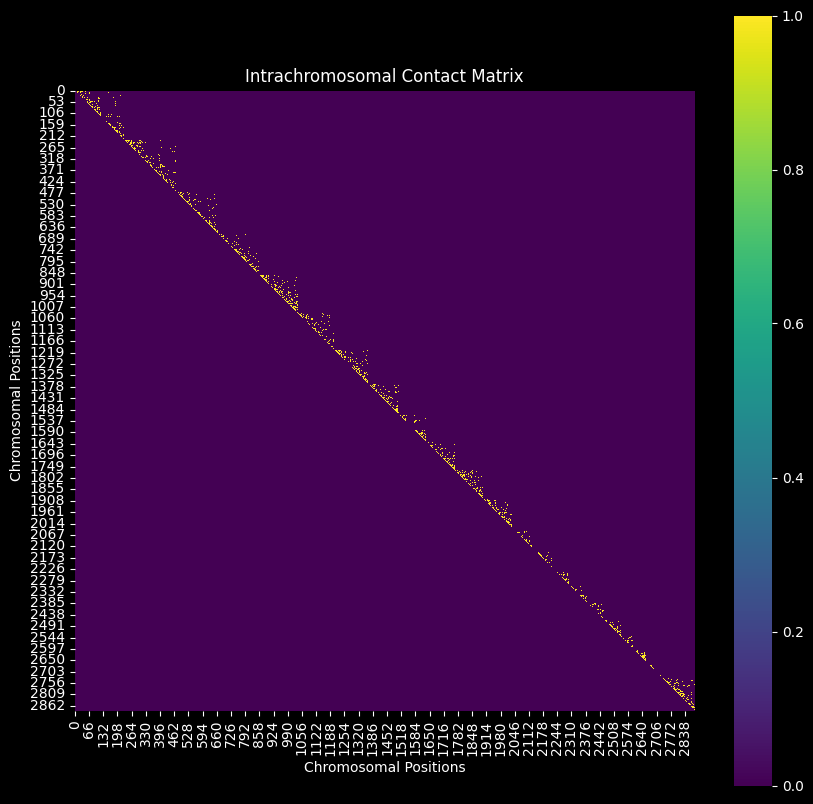

In [141]:
outlier_1331_data = parse_file("Hela/pl2_GAGGAGCA-CGCTTAAT.txt")
outlier_1331 = load_all_chromosome_matrices_for_cell(outlier_1331_data, chromosomes, max_bin)

# Create the large matrix
large_matrix = create_large_intrachromosomal_matrix(outlier_1331, max_bin, chromosomes)

# Plot the large matrix
plot_large_matrix(large_matrix)

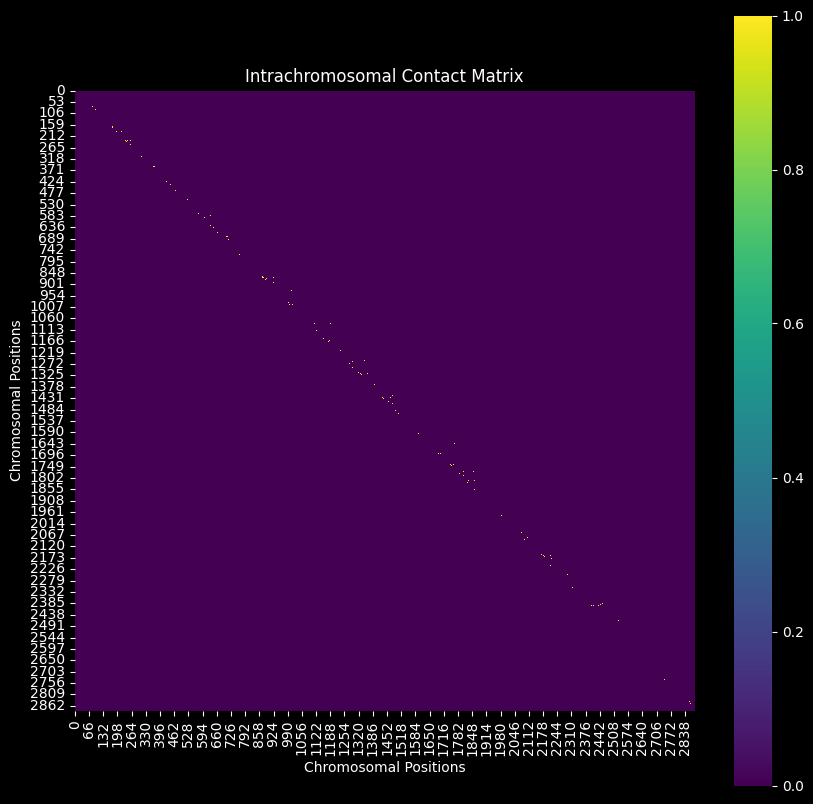

In [142]:
# Normal Cells
normal_hela = parse_file("Hela/ml1_AAGCGACC-TGGTTATC.txt")
normal_hela = load_all_chromosome_matrices_for_cell(normal_hela, chromosomes, max_bin)

# Create the large matrix
large_matrix = create_large_intrachromosomal_matrix(normal_hela, max_bin, chromosomes)

# Plot the large matrix
plot_large_matrix(large_matrix)

# UMAP Visualization

In [45]:
from umap import UMAP
# Configure UMAP hyperparameters
reducer = UMAP(n_neighbors=5, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='cosine', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
               init='random', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0, # default 0.1, The effective minimum distance between embedded points.
               random_state=10
              )
transformed_data = reducer.fit_transform(combined_cells)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [47]:
import plotly.express as px
def chart(X, y):
    #--------------------------------------------------------------------------#
    # This section is not mandatory as its purpose is to sort the data by label 
    # so, we can maintain consistent colors for digits across multiple graphs
    
    # Concatenate X and y arrays
    arr_concat = np.concatenate((X, y.reshape(y.shape[0], 1)), axis=1)
    # Create a Pandas dataframe using the above array
    df = pd.DataFrame(arr_concat, columns=['x', 'y', 'z', 'label'])
    # Convert label data type from float to integer
    df['label'] = df['label'].astype(int)
    # Finally, sort the dataframe by label
    df.sort_values(by='label', axis=0, ascending=True, inplace=True)
    
    # Create a 3D graph
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=df['label'].astype(str), height=900, width=950)

    # Update chart looks
    fig.update_layout(showlegend=True,
                      legend=dict(orientation="h", yanchor="top", y=0, xanchor="center", x=0.5),
                      scene_camera=dict(up=dict(x=0, y=0, z=1), 
                                            center=dict(x=0, y=0, z=-0.1),
                                            eye=dict(x=1.5, y=-1.4, z=0.5)),
                      margin=dict(l=0, r=0, b=0, t=0),
                      scene=dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10)),
                                 zaxis=dict(backgroundcolor='lightgrey',
                                            color='black', 
                                            gridcolor='#f0f0f0',
                                            title_font=dict(size=10),
                                            tickfont=dict(size=10))))
    # Update marker size
    fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))
    
    fig.show()

In [48]:
chart(transformed_data, labels)

In [272]:
reducer1 = UMAP(n_neighbors=30, # default 15, The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
               n_components=3, # default 2, The dimension of the space to embed into.
               metric='cosine', # default 'euclidean', The metric to use to compute distances in high dimensional space.
               n_epochs=1000, # default None, The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. 
               learning_rate=1, # default 1.0, The initial learning rate for the embedding optimization.
               init='random', # default 'spectral', How to initialize the low dimensional embedding. Options are: {'spectral', 'random', A numpy array of initial embedding positions}.
               min_dist=0, # default 0.1, The effective minimum distance between embedded points.
               random_state=10
              )
transformed_data = reducer1.fit_transform(combined_cells)
chart(transformed_data, labels)

/Users/rogersyang/Documents/PhD Application/Research/3D DNA Structure Heterogeneity/DNA3D/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



# PCA on Each Chromosome

In [178]:
def flatten_matrices(matrices):
    """
    Flatten the upper triangular parts of the matrices (excluding the diagonal) into vectors.
    
    Args:
        matrices (list of np.array): List of contact matrices.
    
    Returns:
        np.array: Flattened matrix of shape (n_cells, n_features).
    """
    flattened_data = []
    for matrix in matrices:
        # Flatten only the upper triangular part excluding the diagonal
        flattened_matrix = matrix[np.triu_indices_from(matrix, k=1)]
        flattened_data.append(flattened_matrix)
    
    return np.array(flattened_data)

In [201]:
def chr_process(chr):
    if chr=='X':
        chr = 23
    GM12878 = []
    for file in tqdm(sorted(os.listdir("GM12878"))):
        if file.endswith(".txt"):
            data = parse_file(f"GM12878/{file}")
            if data is not None:
                cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin)
                GM12878.append(cell_matrices[chr-1])

    HAP1 = []
    for file in tqdm(sorted(os.listdir("HAP1"))):
        if file.endswith(".txt") and file not in HAP1_outliers:
            data = parse_file(f"HAP1/{file}")
            if data is not None:
                cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin)
                HAP1.append(cell_matrices[chr-1])

    Hela = []
    for file in tqdm(sorted(os.listdir("Hela"))):
        if file.endswith(".txt") and file not in Hela_outliers:
            data = parse_file(f"Hela/{file}")
            if data is not None:
                cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin)
                Hela.append(cell_matrices[chr-1])

    K562 = []
    for file in tqdm(sorted(os.listdir("K562"))):
        if file.endswith(".txt"):
            data = parse_file(f"K562/{file}")
            if data is not None:
                cell_matrices = load_all_chromosome_matrices_for_cell(data, chromosomes, max_bin)
                K562.append(cell_matrices[chr-1])
                
    flattened_GM12878 = flatten_matrices(GM12878)
    flattened_HAP1 = flatten_matrices(HAP1)
    flattened_Hela = flatten_matrices(Hela)
    flattened_K562 = flatten_matrices(K562)

    # Combine all cells from all types into one matrix
    combined = np.vstack([
        flattened_HAP1,
        flattened_GM12878,
        flattened_Hela,
        flattened_K562
    ])

    labels_chr = (
        [0] * len(flattened_HAP1) +
        [1] * len(flattened_GM12878) +
        [2] * len(flattened_Hela) +
        [3] * len(flattened_K562)
    )
    labels_chr = np.array(labels_chr)
    return combined, labels_chr

In [193]:
from sklearn.decomposition import PCA
def run_PCA(combined, labels_chr):
    

    # Assuming combined_cells is your dataset and labels are stored in 'labels'
    # Example PCA transformation (assuming you have performed PCA)
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(combined)


    fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the figsize as needed

    # Scatter plot with the first and second principal components
    scatter = ax.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels_chr, cmap='cool')

    # Add a color bar for visualization
    plt.colorbar(scatter)

    # Define outlier thresholds for both PC1 and PC2
    pc1_threshold = 58  # Adjust this based on your data for PC1
    pc2_threshold = 20  # Adjust this based on your data for PC2

    # Find outliers for both PC1 and PC2
    outliers_pc1 = np.where(np.abs(transformed_data[:, 0]) > pc1_threshold)[0]
    outliers_pc2 = np.where(np.abs(transformed_data[:, 1]) > pc2_threshold)[0]

    # Combine outliers (either from PC1 or PC2)
    outliers = np.unique(np.concatenate([outliers_pc1, outliers_pc2]))

    # Track the indices for each cell type
    cell_type_indices = {
        'HAP1': np.where(labels_chr == 0)[0],
        'GM12878': np.where(labels_chr == 1)[0],
        'Hela': np.where(labels_chr == 2)[0],
        'K562': np.where(labels_chr == 3)[0]
    }

    # Define a reverse mapping of labels to cell types for annotation
    label_to_cell_type = {
        0: 'HAP1',
        1: 'GM12878',
        2: 'Hela',
        3: 'K562'
    }

    # Annotate outliers
    for i in outliers:
        # Determine the cell type for the current point
        cell_type = label_to_cell_type[labels_chr[i]]
        
        # Find the local index of the point within its cell type
        local_index = np.where(cell_type_indices[cell_type] == i)[0][0]  # +1 for 1-based index
        
        # Annotate the point with the local index and cell type
        ax.annotate(f"{local_index}th in {cell_type}", 
                    (transformed_data[i, 0], transformed_data[i, 1]),
                    textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='red')

    # Plot threshold lines for outlier detection on PC1 (vertical) and PC2 (horizontal)
    ax.axvline(x=pc1_threshold, color='red', linestyle='--', label=f'PC1 Threshold = {pc1_threshold}')
    ax.axvline(x=-pc1_threshold, color='red', linestyle='--')

    ax.axhline(y=pc2_threshold, color='blue', linestyle='--', label=f'PC2 Threshold = {pc2_threshold}')
    ax.axhline(y=-pc2_threshold, color='blue', linestyle='--')

    # Set plot title and labels
    ax.set_title('PCA of Cell Contact Data with Outliers Annotated')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')

    # Show legend for threshold lines
    plt.legend()

    # Show the plot
    plt.show()

    # List of the outliers
    print(f"Outliers identified: {outliers}")
    for i in outliers:
        cell_type = label_to_cell_type[labels_chr[i]]
        local_index = np.where(cell_type_indices[cell_type] == i)[0][0]
        print(f"Outlier {i}: {local_index}th data point in {cell_type}")


100%|██████████| 48/48 [00:02<00:00, 19.88it/s]


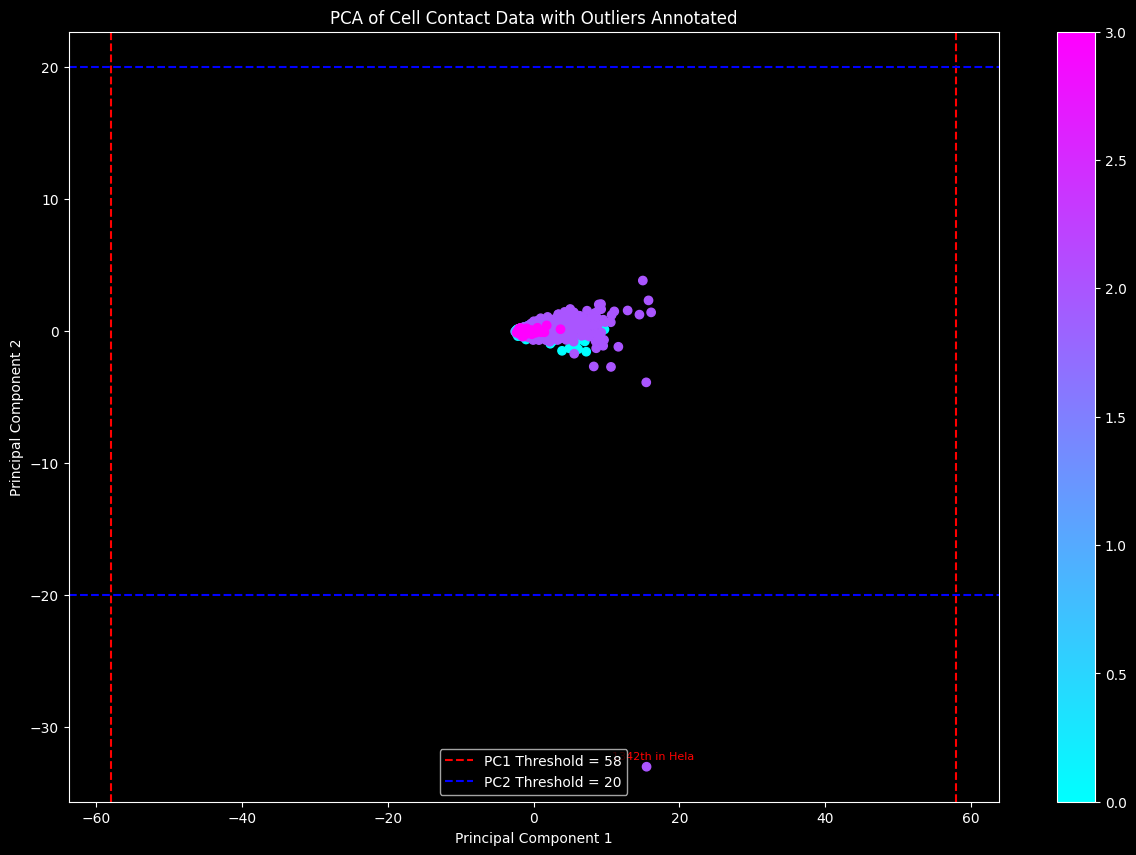

Outliers identified: [2281]
Outlier 2281: 1342th data point in Hela


In [203]:
c, l = chr_process(1)
run_PCA(c, l)

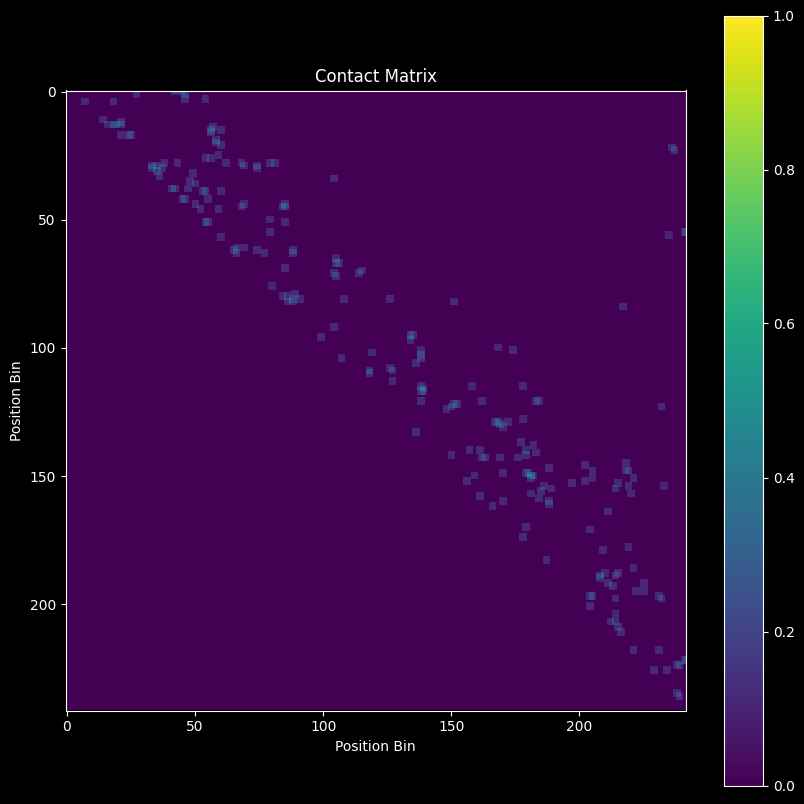

In [260]:
def visualize(matrix, vmax) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(matrix, cmap='viridis', interpolation='none', vmin=0, vmax=vmax)
    plt.colorbar()
    plt.title('Contact Matrix')
    plt.xlabel('Position Bin')
    plt.ylabel('Position Bin')
    plt.show()

visualize(HAP1_matrices[0][1], 1)

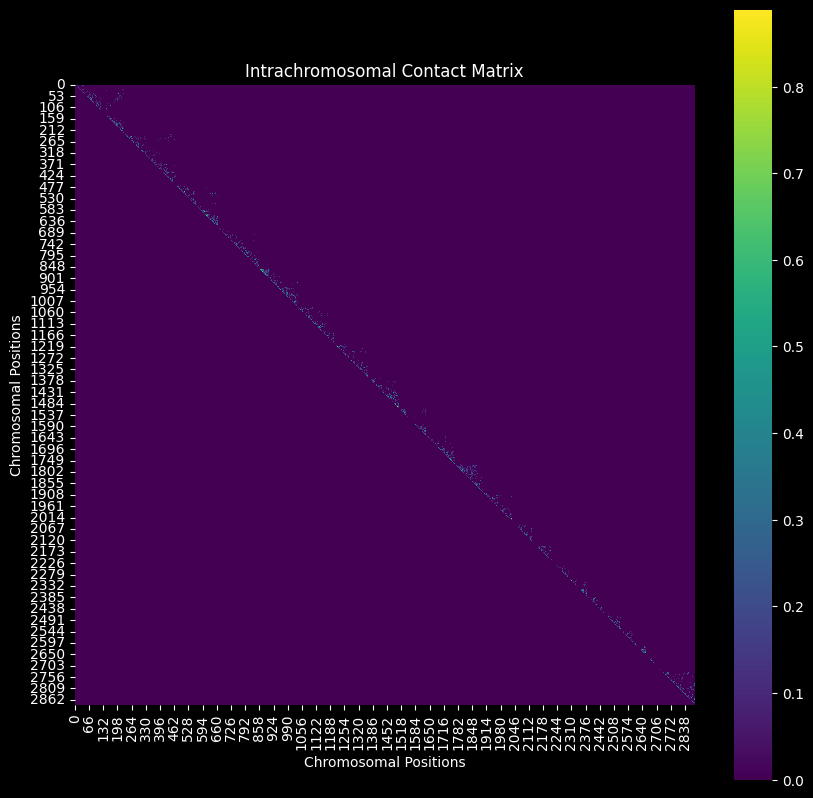

(2884, 2884)

In [277]:
large_matrix = create_large_intrachromosomal_matrix(Hela_matrices[2], max_bin, chromosomes)
plot_large_matrix(large_matrix)
large_matrix.shape